<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/utterance_generation/Utterance%20Generation%20with%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
TASK_DATA_DIR = 'glue_data/QQP'
!test -d glue_data || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git glue_data
!test -d $TASK_DATA_DIR || python glue_data/download_glue_data.py --data_dir glue_data --tasks=QQP
!ls -alh $TASK_DATA_DIR

Cloning into 'glue_data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
total 104M
drwxr-xr-x 3 root root 4.0K Jun 25 16:43 .
drwxr-xr-x 4 root root 4.0K Jun 25 16:43 ..
-rw-r--r-- 1 root root 5.6M Jun 25 16:43 dev.tsv
drwxr-xr-x 2 root root 4.0K Jun 25 16:43 original
-rw-r--r-- 1 root root  49M Jun 25 16:43 test.tsv
-rw-r--r-- 1 root root  50M Jun 25 16:43 train.tsv


In [63]:
import time
import random
import math
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data, vocab

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
train_df = pd.read_csv(TASK_DATA_DIR + '/train.tsv', sep='\t', error_bad_lines=False)
valid_df = pd.read_csv(TASK_DATA_DIR + '/dev.tsv', sep='\t', error_bad_lines=False)
train_df.head()

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [7]:
len(train_df), len(valid_df)

(363192, 40372)

Text(0.5, 0, 'Train data distribution')

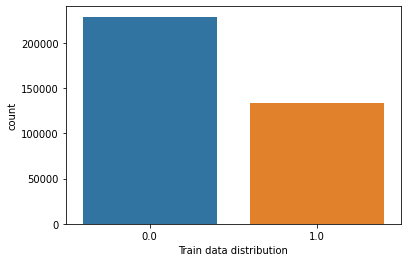

In [8]:
sns.countplot(train_df['is_duplicate'])
plt.xlabel('Train data distribution')

Text(0.5, 0, 'Valid data distribution')

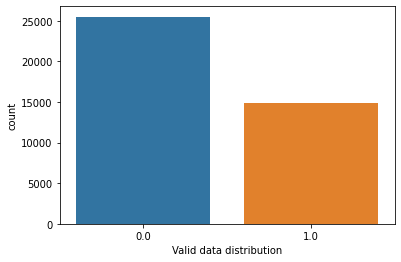

In [9]:
sns.countplot(valid_df['is_duplicate'])
plt.xlabel('Valid data distribution')

In [10]:
train_data = train_df[train_df['is_duplicate'] == 1]
valid_data = valid_df[valid_df['is_duplicate'] == 1]

In [11]:
len(train_data), len(valid_data)

(134141, 14857)

In [12]:
train_data = train_data[['question1', 'question2']]
valid_data = valid_data[['question1', 'question2']]

In [13]:
train_data.head()

,question1,question2
1,How do I control my horny emotions?,How do you control your horniness?
3,What can one do after MBBS?,What do i do after my MBBS ?
7,What is the best self help book you have read?...,What are the top self help books I should read?
11,What will be Hillary Clinton's policy towards ...,What will be Hilary Clinton's policy towards I...
13,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?


In [14]:
sample_train_data = train_data.sample(50000)
sample_valid_data = valid_data.sample(5000)

In [15]:
sample_train_data.to_csv('train_ds.csv')
sample_valid_data.to_csv('valid_ds.csv')

In [16]:
!ls -lah

total 6.1M
drwxr-xr-x 1 root root 4.0K Jun 25 16:44 .
drwxr-xr-x 1 root root 4.0K Jun 25 16:22 ..
drwxr-xr-x 1 root root 4.0K Jun 19 16:15 .config
drwxr-xr-x 4 root root 4.0K Jun 25 16:43 glue_data
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw-r--r-- 1 root root 5.5M Jun 25 16:44 train_ds.csv
-rw-r--r-- 1 root root 558K Jun 25 16:44 valid_ds.csv


In [17]:
tokenizer = data.get_tokenizer('spacy')
TEXT = data.Field(tokenize=tokenizer, lower=True, init_token='<sos>', eos_token='<eos>', batch_first=True)

In [18]:
fields = [(None, None), ("source", TEXT), ("target", TEXT)]

train_dataset, valid_dataset = data.TabularDataset.splits(path='.',
                                     train='train_ds.csv', validation='valid_ds.csv',
                                     format='csv', skip_header=True, fields=fields)

In [19]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(valid_dataset)}")

Number of training examples: 50000
Number of validation examples: 5000


In [20]:
print(vars(train_dataset.examples[1]))

{'source': ['what', 'are', 'complex', 'networks', '?'], 'target': ['what', 'defines', 'a', 'complex', 'network', '?']}


In [21]:
TEXT.build_vocab(train_dataset, min_freq=5)

In [22]:
print(f"Number of tokens in vocabulary: {len(TEXT.vocab)}")

Number of tokens in vocabulary: 8130


In [23]:
BATCH_SIZE = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.source),
    device=device
)

In [24]:
# sample checking
temp = next(iter(train_iterator))
temp.source.shape, temp.target.shape

(torch.Size([64, 32]), torch.Size([64, 47]))

In [67]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, pad_idx, device):
        super().__init__()

        assert d_model % n_heads == 0, "n_heads must be a factor of d_model"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.fc = nn.Linear(d_model, d_model)

        self.pad_idx = pad_idx
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        # query => [batch_size, seq_len, d_model] 
        # key => [batch_size, seq_len, d_model]
        # value => [batch_size, seq_len, d_model]

        batch_size = query.shape[0]

        Q = self.q(query)
        K = self.k(key)
        V = self.v(value)
        # Q, K, V => [batch_size, seq_len, d_model]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q, K, V => [batch_size, n_heads, seq_len, head_dim]

        energy = torch.matmul(Q, K.permute(0 ,1, 3, 2))
        energy = energy / self.scale
        # energy => [batch_size, n_heads, query_len, key_len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        # attention => [batch_size, n_heads, query_len, key_len]

        weighted = torch.matmul(attention, V)
        # weighted => [batch_size, n_heads, query_len, head_dim]

        weighted = weighted.permute(0, 2, 1, 3).contiguous()
        # weighted => [batch_size, query_len, n_heads, head_dim]

        x = weighted.view(batch_size, -1, self.d_model)
        # x => [batch_size, query_len, d_model]

        x = self.fc(x)
        # x => [batch_size, query_len, d_model]
        # attention => [batch_size, n_heads, query_len, key_len]

        return x, attention


In [68]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, pff_dim, dropout):
        super().__init__()

        self.fc1 = nn.Linear(d_model, pff_dim)
        self.fc2 = nn.Linear(pff_dim, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        # input => [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.fc1(input)))
        # x => [batch_size, seq_len, pff_dim]

        x = self.fc2(x)
        # x => [batch_size, seq_len, d_model]

        return x


In [69]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, pad_idx, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, pad_idx, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src => [batch_size, src_len, d_model]

        # self attention on src
        _src, _ = self.self_attention(src, src, src, src_mask)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        # position wise feed forward
        _src = self.pff(src)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.pff_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        return src

In [70]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, n_heads, pff_dim, dropout, pad_idx, device, max_len=500):
        super().__init__()

        self.n_layers = n_layers
        self.device = device
        self.word_embedding = nn.Embedding(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pff_dim, dropout, pad_idx, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, src, src_mask=None):
        # src => [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, src_len]

        word_embed = self.word_embedding(src)
        word_embed = word_embed * self.scale
        # word_embed => [batch_size, src_len, d_model]

        pos_embed = self.pos_embedding(pos)
        # pos_embed => [batch_size, src_len, d_model]

        src = self.dropout(word_embed + pos_embed)
        # src => [batch_size, src_len, d_model]

        for layer in self.layers:
            src = layer(src, src_mask)
        
        # src => [batch_size, src_len, d_model]
        return src


In [71]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, pad_idx, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, pad_idx, device)
        self.enc_attention = SelfAttention(d_model, n_heads, dropout, pad_idx, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # enc_attention
        _trg, attention = self.enc_attention(trg, enc_src, enc_src, src_mask)
        # _trg => [batch_size, trg_len, d_model]
        # attention => [batch_size, n_heads, trg_len, src_len]

        # residual connection and layer normalization
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # positionwise feed forward
        _trg = self.pff(trg)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.pff_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        return trg, attention


In [72]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, n_heads, pff_dim, dropout, pad_idx, device, max_len=500):
        super().__init__()
        
        self.device = device
        self.word_embedding = nn.Embedding(output_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pff_dim, dropout, pad_idx, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(d_model, output_dim)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, trg, enc_src, trg_mask=None, src_mask=None):

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, trg_len]

        word_embedding = self.word_embedding(trg)
        word_embedding = word_embedding * self.scale
        # word_embedding => [batch_size, trg_len, d_model]

        pos_embedding = self.pos_embedding(pos)
        # pos_embedding => [batch_size, trg_len, d_model]

        trg = self.dropout(word_embedding + pos_embedding)
        # trg => [batch_size, trg_len, d_model]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        logits = self.fc_out(trg)
        # logits => [batch_size, trg_len, output_dim]
        # attention => [batch_size, n_heads, trg_len, src_len]

        return logits, attention


In [73]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        # src_mask => [batch_size, 1, 1, src_len]
        
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask => [batch_size, 1, trg_len, trg_len]

        return trg_mask
 
    def forward(self, src, trg):
        # src => [batch_size, src_len]
        # trg => [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention

In [74]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
INPUT_DIM = len(TEXT.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT,
              PAD_IDX,
              device)

dec = Decoder(INPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              PAD_IDX,
              device)

In [75]:
model = Transformer(enc, dec, PAD_IDX, device).to(device)

In [76]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(8130, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): SelfAttention(
          (q): Linear(in_features=256, out_features=256, bias=True)
          (k): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (pff): PositionWiseFeedForward(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (pff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,461,634 trainable parameters


In [78]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [79]:
def train(model, iterator, criterion, optimizer, clip):
    model.train()

    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.source
        trg = batch.target

        optimizer.zero_grad()

        output, _ = model(src, trg[:, :-1])
        # output => [batch_size, trg_len - 1, output_dim]
        # trg => [batch_size, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


In [80]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.source
            trg = batch.target

            output, _ = model(src, trg[:, :-1])
            # output => [batch_size, trg_len - 1, output_dim]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [81]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [82]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, criterion, optimizer, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss): 7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss): 7.3f}")

Epoch: 01 | Time: 1m 31.29673933982849s
	Train Loss: 4.044 | Train PPL:  57.053
	Valid Loss: 3.099 | Valid PPL:  22.167
Epoch: 02 | Time: 1m 30.828892946243286s
	Train Loss: 2.950 | Train PPL:  19.105
	Valid Loss: 2.605 | Valid PPL:  13.526
Epoch: 03 | Time: 1m 31.328993558883667s
	Train Loss: 2.496 | Train PPL:  12.138
	Valid Loss: 2.364 | Valid PPL:  10.632
Epoch: 04 | Time: 1m 31.4201500415802s
	Train Loss: 2.208 | Train PPL:   9.095
	Valid Loss: 2.234 | Valid PPL:   9.336
Epoch: 05 | Time: 1m 31.597260236740112s
	Train Loss: 2.003 | Train PPL:   7.411
	Valid Loss: 2.148 | Valid PPL:   8.568
Epoch: 06 | Time: 1m 30.995921850204468s
	Train Loss: 1.848 | Train PPL:   6.345
	Valid Loss: 2.101 | Valid PPL:   8.173
Epoch: 07 | Time: 1m 31.46178436279297s
	Train Loss: 1.728 | Train PPL:   5.631
	Valid Loss: 2.055 | Valid PPL:   7.809
Epoch: 08 | Time: 1m 31.24697494506836s
	Train Loss: 1.630 | Train PPL:   5.102
	Valid Loss: 2.064 | Valid PPL:   7.874
Epoch: 09 | Time: 1m 30.8767623901367

In [83]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [84]:
def generate_utterance_greedy(sentence, text_field, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [text_field.init_token] + tokens + [text_field.eos_token]
    
    # convert the tokens to ids  
    src_indexes = [text_field.vocab.stoi[token] for token in tokens]

    # convert to tensor format
    # since the inference is done on single sentence, batch size is 1
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    # src_tensor => [1, seq_len]

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    # the starting input to decoder is always <sos>
    trg_indexes = [text_field.vocab.stoi[text_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()

        trg_indexes.append(pred_token)

        # if the predicted token is <eos> means stop the decoding
        if pred_token == text_field.vocab.stoi[text_field.eos_token]:
            break
    
    # convert the predicted token ids to words
    trg_tokens = [text_field.vocab.itos[i] for i in trg_indexes]

    return tokens[1:-1], trg_tokens[1:], attention


In [105]:
def generate_utterance_beam(sentence, text_field, model, device, max_len=50, beam_size=10, length_norm_coefficient=0.6):
    with torch.no_grad():
        k = beam_size

        # minimum number of hypotheses to complete
        n_completed_hypotheses = min(k, 10)

        # vocab size
        vocab_size = len(text_field.vocab)

        if isinstance(sentence, str):
            nlp = spacy.load('en')
            tokens = [token.text.lower() for token in nlp(sentence)]
        else:
            tokens = [token.lower() for token in sentence]
        
        tokens = [text_field.init_token] + tokens + [text_field.eos_token]
        
        # convert the tokens to ids  
        src_indexes = [text_field.vocab.stoi[token] for token in tokens]

        # convert to tensor format
        # since the inference is done on single sentence, batch size is 1
        src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
        # src_tensor => [1, src_len]

        # encode
        enc_src = model.encoder(src_tensor)
        # enc_src => [1, src_len, d_model]

        # Our hypothesis to begin with is just <sos>
        hypotheses = torch.LongTensor([[text_field.vocab.stoi[text_field.init_token]]]).to(device)  # (1, 1)

        # Tensor to store hypotheses' scores; now it's just 0
        hypotheses_scores = torch.zeros(1).to(device)  # (1)

        # Lists to store completed hypotheses and their scores
        completed_hypotheses = list()
        completed_hypotheses_scores = list()

        # Start decoding
        step = 1

        # Assume "s" is the number of incomplete hypotheses currently in the bag; a number less than or equal to "k"
        # At this point, s is 1, because we only have 1 hypothesis to work with, i.e. "<sos>"
        while True:
            s = hypotheses.size(0)
            trg_mask = model.make_trg_mask(hypotheses)
            decoder_sequences, _ = model.decoder(hypotheses, enc_src.repeat(s, 1, 1), trg_mask)
            # decoder_sequences => [s, step_size, vocab_size]

            # Scores at this step
            scores = decoder_sequences[:, -1, :]  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=-1)  # (s, vocab_size)

            # Add hypotheses' scores from last step to scores at this step to get scores for all possible new hypotheses
            scores = hypotheses_scores.unsqueeze(1) + scores  # (s, vocab_size)

            # Unroll and find top k scores, and their unrolled indices
            top_k_hypotheses_scores, unrolled_indices = scores.view(-1).topk(k, 0, True, True)  # (k)

            # Convert unrolled indices to actual indices of the scores tensor which yielded the best scores
            prev_word_indices = unrolled_indices // vocab_size  # (k)
            next_word_indices = unrolled_indices % vocab_size  # (k)

            # Construct the the new top k hypotheses from these indices
            top_k_hypotheses = torch.cat([hypotheses[prev_word_indices], next_word_indices.unsqueeze(1)],
                                         dim=1)  # (k, step + 1)
            
            # Which of these new hypotheses are complete (reached <eos>)?
            complete = next_word_indices == text_field.vocab.stoi[text_field.eos_token]  # (k), bool

            # Set aside completed hypotheses and their scores normalized by their lengths
            # For the length normalization formula, see
            # "Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation"
            completed_hypotheses.extend(top_k_hypotheses[complete].tolist())
            norm = math.pow(((5 + step) / (5 + 1)), length_norm_coefficient)
            completed_hypotheses_scores.extend((top_k_hypotheses_scores[complete] / norm).tolist())

            # Stop if we have completed enough hypotheses
            if len(completed_hypotheses) >= n_completed_hypotheses:
                break

            # Else, continue with incomplete hypotheses
            hypotheses = top_k_hypotheses[~complete]  # (s, step + 1)
            hypotheses_scores = top_k_hypotheses_scores[~complete]  # (s)
            hypotheses_lengths = torch.LongTensor(hypotheses.size(0) * [hypotheses.size(1)]).to(device)  # (s)

            # Stop if things have been going on for too long
            if step > 100:
                break
            step += 1
        
        # If there is not a single completed hypothesis, use partial hypotheses
        if len(completed_hypotheses) == 0:
            completed_hypotheses = hypotheses.tolist()
            completed_hypotheses_scores = hypotheses_scores.tolist()
        
        # Decode the hypotheses
        all_hypotheses = list()
        for i, hypo in enumerate(completed_hypotheses):
            h = [text_field.vocab.itos[idx] for idx in hypo]
            all_hypotheses.append({"hypothesis": h, "score": completed_hypotheses_scores[i]})
        
        # Find the best scoring completed hypothesis
        i = completed_hypotheses_scores.index(max(completed_hypotheses_scores))
        best_hypothesis = all_hypotheses[i]["hypothesis"]

        return tokens[1:-1], best_hypothesis, all_hypotheses

In [90]:
def display_attention(sentence, utterance, attention, n_heads=8, n_rows=2, n_cols=4):
    
    fig = plt.figure(figsize=(25, 12))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='Blues')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + utterance)
        title = f"Attention Head: {i+1}"
        ax.set_xlabel(title)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

src = ['which', 'book', 'would', 'you', 'recommend', 'to', 'improve', 'english', '?']
trg = ['what', 'are', 'the', 'books', 'to', 'improve', 'english', '?']

greedy generated utterance = what are some suggestions for english ?

All beam generated utterances:
------------------------------
what are the best books for english ?
what is the best book for english ?
what are the best books on quora ?
what are the best books to learn english ?


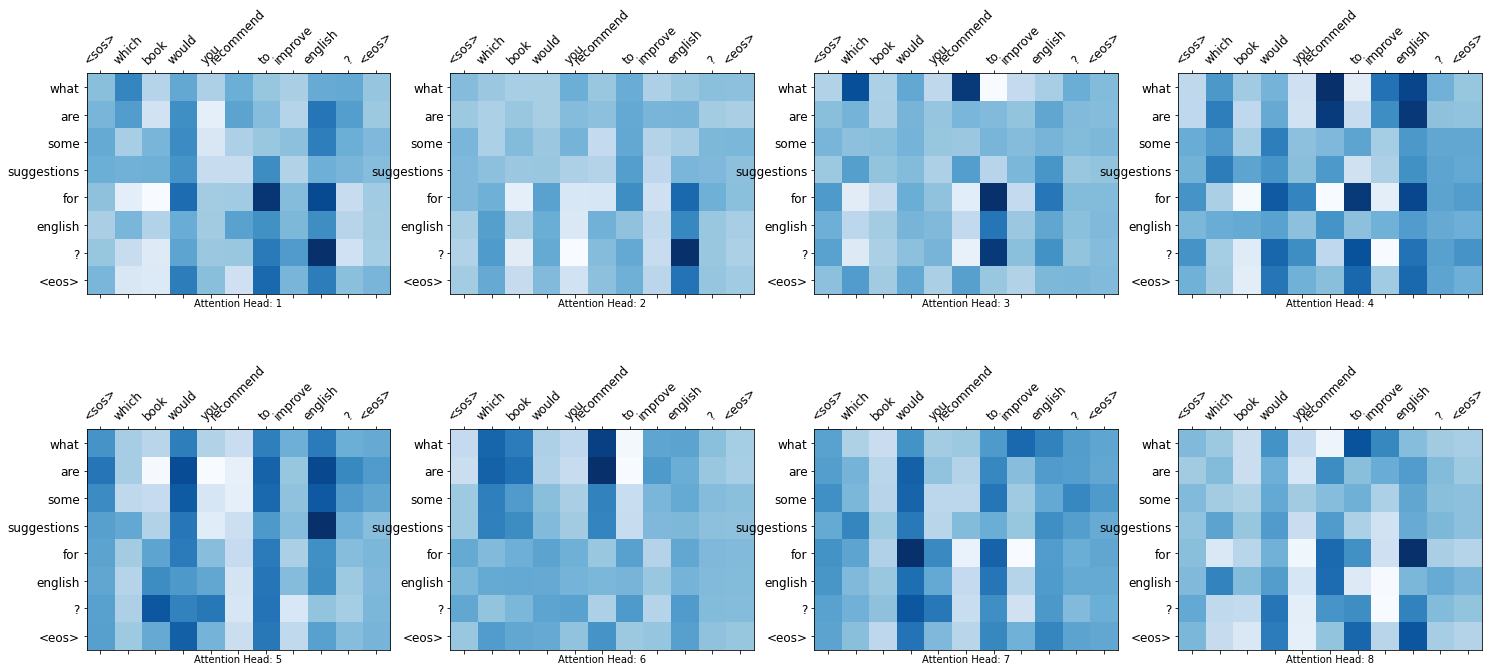

In [104]:
example_idx = 55

src = vars(valid_dataset.examples[example_idx])['source']
trg = vars(valid_dataset.examples[example_idx])['target']

print(f'src = {src}')
print(f'trg = {trg}\n')


_, utterance, attention = generate_utterance_greedy(src, TEXT, model, device)
_, best_one, all_utterances = generate_utterance_beam(src, TEXT, model, device)

print(f'greedy generated utterance = {" ".join(utterance[:-1])}\n')
print("All beam generated utterances:")
print("------------------------------")
for i in all_utterances:
    print(f'{" ".join(i["hypothesis"][1:-1])}')

display_attention(src, utterance, attention)

In [107]:
src = "What can I do after engineering?"

tokens, utterance, attention = generate_utterance_greedy(src, TEXT, model, device)
_, _, all_utterances = generate_utterance_beam(src, TEXT, model, device)
print(f'src = {src}\n')
print(f'Greedy generated utterance = {" ".join(utterance[:-1])}\n')
print("Beam generated utterances:")
print("------------------------------")
for i in all_utterances:
    print(f'{" ".join(i["hypothesis"][1:-1])}')

# display_attention(tokens, utterance, attention)

src = What can I do after engineering?

Greedy generated utterance = what should i do after engineering ?

Beam generated utterances:
------------------------------
what happens after engineering ?
what should i do after engineering ?
what should i do after diploma ?
what do i do after engineering ?
what should we do after engineering ?
what can i do after engineering ?
what should i do after completing engineering ?
how do i pursue engineering after engineering ?
what are the career options after engineering ?
what should i do after i pursue engineering ?
what should i do after engineering after engineering ?


In [110]:
src = "How do I motivate myself?"

tokens, utterance, attention = generate_utterance_greedy(src, TEXT, model, device)
_, _, all_utterances = generate_utterance_beam(src, TEXT, model, device)
print(f'src = {src}\n')
print(f'Greedy generated utterance = {" ".join(utterance[:-1])}\n')
print("Beam generated utterances:")
print("------------------------------")
for i in all_utterances:
    print(f'{" ".join(i["hypothesis"][1:-1])}')


src = How do I motivate myself?

Greedy generated utterance = how do i motivate myself to do hard ?

Beam generated utterances:
------------------------------
how do i motivate myself ?
how can i motivate myself ?
how do you motivate myself ?
how do i motivate myself to sleep ?
how do i motivate myself to do ?
how can i motivate myself to sleep ?
how do i motivate myself to do hard ?
how do i motivate myself to do myself ?
how do i motivate myself to do it ?
how do i motivate myself to do a hard ?
